Ablation Experiments

2025-08-09 10:07:04.332714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754716024.494698    2189 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754716024.553237    2189 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-09 10:07:04.728802: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-09 10:07:17.032225: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNER_lambda_05_weights.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNER_without_SN_lambda_05_weights.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNER_without_dynamic_weights_lambda_05_weights.keras


/home/waleed/.local/lib/python3.10/site-packages/tf_keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomUniform'>, which may lead to improper serialization.
  warnings.warn(


Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNGP_gamma_1_weights.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNGP_without_SN_gamma_1_weights.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNGP_without_dynamic_weights_gamma_1_weights.keras
449/449 [==============================] - 79s 176ms/step


2025-08-09 10:09:53.010791: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 823690000 exceeds 10% of free system memory.
2025-08-09 10:10:04.090581: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 823690000 exceeds 10% of free system memory.
2025-08-09 10:10:16.853455: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 823690000 exceeds 10% of free system memory.


449/449 [==============================] - 3s 7ms/step


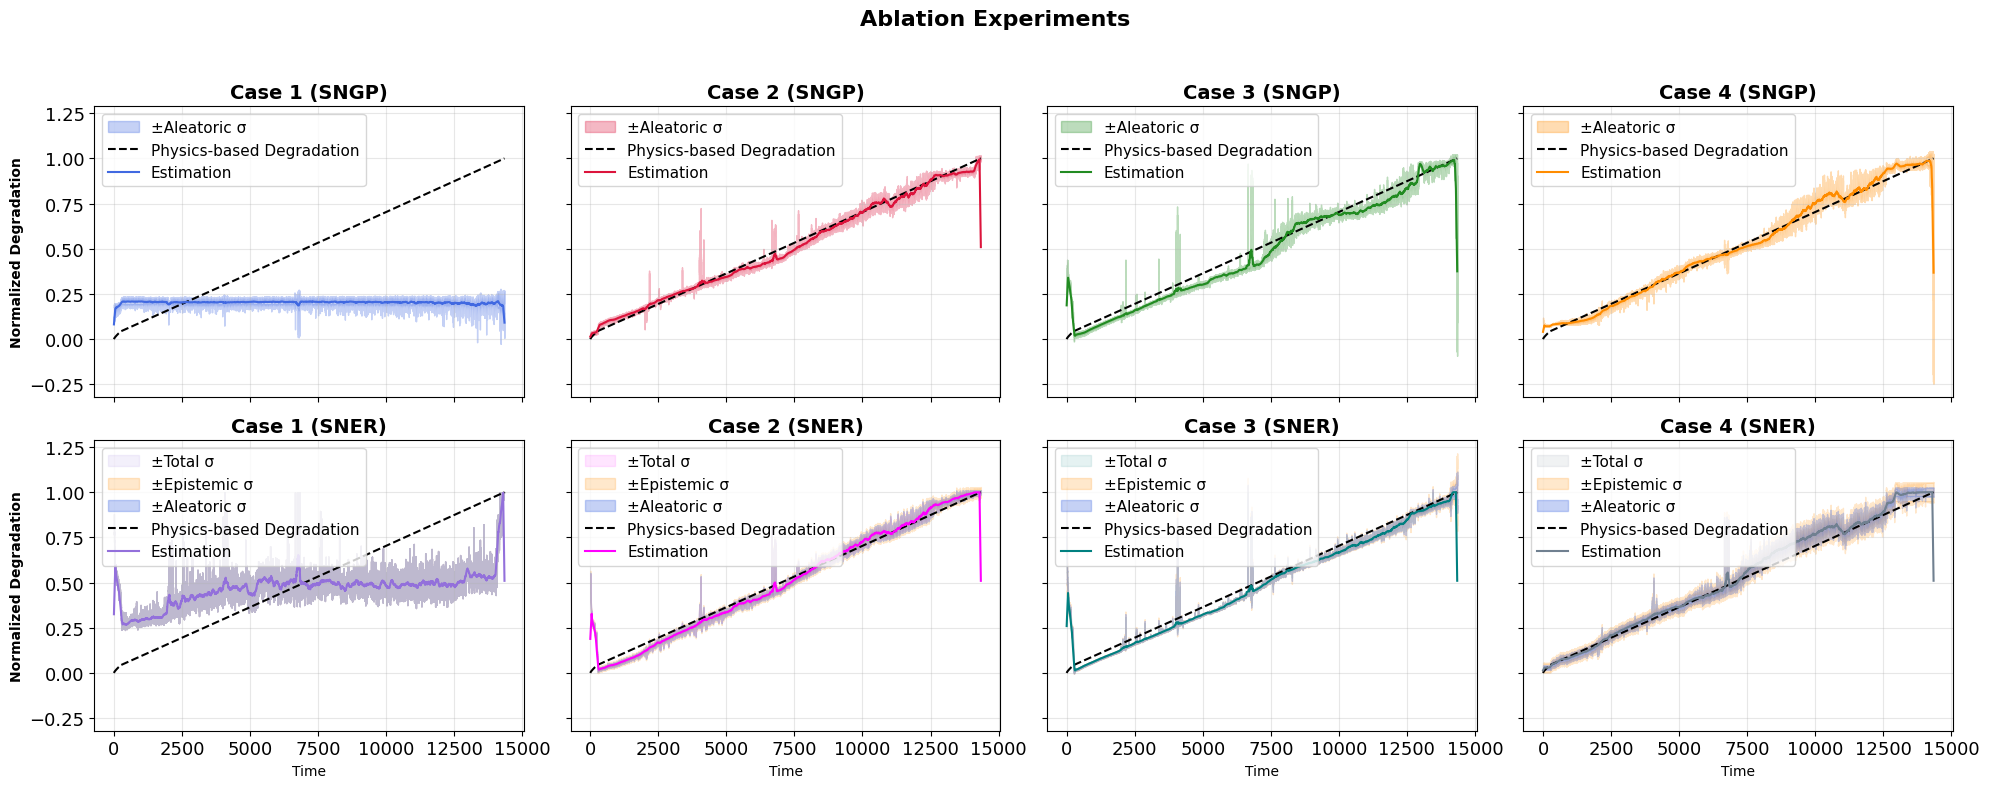

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from utils.preprocess import process_features, moving_average
from networks.UQ_networks import SNER_network, ER_network, SNGP_network, GP_network
from models.UQ_SNGP import UQ_SNGP
from models.UQ_SNER import UQ_SNER

from evidential_deep_learning.losses import EvidentialRegression as edl_loss
from networks.losses import NLL
import tensorflow as tf
from utils.metrics import DAC,score_function

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13


# --- Setup directories ---
root_dir = os.getcwd()
feature_dir = os.path.join(root_dir, 'tf_features')
weights_dir = os.path.join(root_dir, 'model_weights')
stat_dir = os.path.join(root_dir, 'statistics')
results = []
# --- Define models (SNER) ---
lambbda = 0.5

sner_05 = UQ_SNER(SNER_network, lambbda=lambbda)
sner_05.load_weights(os.path.join(weights_dir, 'PI_SNER_lambda_05_weights.keras'))

sner_without_sn = UQ_SNER(ER_network, lambbda=lambbda)
sner_without_sn.load_weights(os.path.join(weights_dir, 'PI_SNER_without_SN_lambda_05_weights.keras'))

sner_without_dynamic_weights = UQ_SNER(SNER_network, lambbda=lambbda)
sner_without_dynamic_weights.load_weights(os.path.join(weights_dir, 'PI_SNER_without_dynamic_weights_lambda_05_weights.keras'))

sner_without_pg = SNER_network()
sner_without_pg.load_weights(os.path.join(weights_dir, 'SNER_without_physics_guidance_lambda_05_weights.keras'))
sner_without_pg.compile(optimizer='adam', loss=edl_loss)

# --- Define models (SNGP) ---
gamma = 1.0

sngp_1 = UQ_SNGP(SNGP_network, gamma=gamma)
sngp_1.load_weights(os.path.join(weights_dir, 'PI_SNGP_gamma_1_weights.keras'))

sngp_without_sn = UQ_SNGP(GP_network, gamma=gamma)
sngp_without_sn.load_weights(os.path.join(weights_dir, 'PI_SNGP_without_SN_gamma_1_weights.keras'))

sngp_without_dynamic_weights = UQ_SNGP(SNGP_network, gamma=gamma)
sngp_without_dynamic_weights.load_weights(os.path.join(weights_dir, 'PI_SNGP_without_dynamic_weights_gamma_1_weights.keras'))

sngp_without_pg = SNGP_network()
sngp_without_pg.load_weights(os.path.join(weights_dir, 'SNGP_without_physics_guidance_gamma_1_weights.keras'))
sngp_without_pg.compile(optimizer='adam', loss=NLL)


#define MC models


# --- Define model dictionaries ---
sner_models_dict = {
    "Case 1 (SNER)": sner_without_pg,
    "Case 2 (SNER)": sner_without_dynamic_weights,
    "Case 3 (SNER)": sner_without_sn,
    "Case 4 (SNER)": sner_05
}

sngp_models_dict = {
    "Case 1 (SNGP)": sngp_without_pg,
    "Case 2 (SNGP)": sngp_without_dynamic_weights,
    "Case 3 (SNGP)": sngp_without_sn,
    "Case 4 (SNGP)": sngp_1
}

# Merge all models into a single dictionary
all_models_dict = {**sngp_models_dict, **sner_models_dict}

# --- Load Bearing1_1 data ---
bearing_name = "Bearing1_1"
try:
    df = pd.read_csv(os.path.join(feature_dir, f"{bearing_name}_features.csv"))

    xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
    xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
    vibration_features = np.concatenate((xh, xv), axis=-1)
    t_data = df['Time'].values.reshape(-1, 1)
    T_data = (df['Temperature'].values + 273.15).reshape(-1, 1)
    X = np.concatenate([vibration_features, t_data, T_data], axis=1)
    X = StandardScaler().fit_transform(X)
    y_true = df['Degradation'].values

except Exception as e:
    print(f"Failed to load bearing data: {e}")
    raise

# --- Plot Setup ---
plt.style.use('seaborn-v0_8-deep')
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)

# Define subtle but distinct colors
color_aleatoric = 'royalblue'
color_epistemic = 'darkorange'
color_total = 'forestgreen'
colors = ['royalblue', 'crimson', 'forestgreen', 'darkorange', 'mediumpurple', 'magenta', 'teal', 'slategray']

for i, (model_name, model) in enumerate(all_models_dict.items()):
    row = 0 if i < 4 else 1
    col = i % 4
    ax = axes[row, col]

    try:
        x_vals = np.arange(len(X))
        is_sner_model = False

        # --- Unified handling for SNER models ---
        if isinstance(model, UQ_SNER):
            mu, aleatoric, epistemic, total_var = model._predict(X)
            is_sner_model = True

        elif model is sner_without_pg:
            pred = model.predict(X)
            mu = pred[:, 0]
            alpha = pred[:, 1]
            beta = pred[:, 2]
            v = pred[:, 3]
            mu = np.clip(mu, 0, 1).flatten()
            aleatoric = np.clip(beta / (alpha - 1),0,1)
            epistemic = np.clip(beta / (v * (alpha - 1)),0,1)
            var = aleatoric + epistemic
            is_sner_model = True

        if is_sner_model:
            mu = np.clip(mu, 0, 1).flatten()
            std_aleatoric = np.sqrt(aleatoric)
            std_epistemic = np.sqrt(epistemic)
            std_total = np.sqrt(var)

            lower_aleatoric = mu - std_aleatoric
            upper_aleatoric = mu + std_aleatoric

            lower_epistemic = lower_aleatoric - std_epistemic
            upper_epistemic = upper_aleatoric + std_epistemic

            lower_total = mu - std_total
            upper_total = mu + std_total

            ax.fill_between(x_vals, lower_total, upper_total,
                            color=colors[i], alpha=0.1, label='±Total σ')
            ax.fill_between(x_vals, lower_epistemic, upper_epistemic,
                            color=color_epistemic, alpha=0.2, label='±Epistemic σ')
            ax.fill_between(x_vals, lower_aleatoric, upper_aleatoric,
                            color=color_aleatoric, alpha=0.3, label='±Aleatoric σ')

        # --- SNGP models ---
        else:
            mu, var = model.predict(X)
            mu = np.clip(mu, 0, 1).flatten()

            if isinstance(var, tf.RaggedTensor):
                var = var.to_tensor()[:, None].numpy().squeeze()
                var = np.mean(var, axis=1)

            std_aleatoric = np.sqrt(np.clip(var, 0, 1))
            lower_aleatoric = mu - std_aleatoric
            upper_aleatoric = mu + std_aleatoric

            ax.fill_between(x_vals, lower_aleatoric, upper_aleatoric,
                         color=colors[i], alpha=0.3, label='±Aleatoric σ')

        

        # --- Common Plotting ---
        ax.plot(y_true, label='Physics-based Degradation', color='black', linestyle='--')
        ax.plot(x_vals, moving_average(mu), label='Estimation', color=colors[i])

        ax.set_title(model_name, fontsize=14, fontweight='bold')
        ax.grid(alpha=0.3)
        if col == 0:
            ax.set_ylabel("Normalized Degradation", fontweight='bold')
        if row == 1:
            ax.set_xlabel("Time")

        # De-duplicate legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), fontsize=11, loc='upper left')

        results.append({
            'Bearing': bearing_name,
            'Model_type': 'SNER' if is_sner_model else 'SNGP',
            'Model': model_name,
            'MSE': mean_squared_error(y_true, mu),
            'MAE': mean_absolute_error(y_true, mu),
            'Score': score_function(y_true, mu).numpy(),
            })



    except Exception as e:
        print(f"Error in model {model_name}: {e}")

# Final formatting
plt.suptitle("Ablation Experiments", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# update the csv
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(stat_dir, 'Paper05_ablation_results.csv'), index=False)


DAC for Ablation

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from utils.preprocess import process_features, moving_average
from networks.UQ_networks import SNER_network, ER_network, SNGP_network, GP_network
from models.UQ_SNGP import UQ_SNGP
from models.UQ_SNER import UQ_SNER
from evidential_deep_learning.losses import EvidentialRegression as edl_loss
from networks.losses import NLL
import tensorflow as tf
from utils.metrics import DAC,score_function
from scipy.spatial import ckdtree

# --- Directories ---
feature_dir = 'tf_features'
weights_dir = 'model_weights'
stat_dir = 'statistics'


plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13



# --- Define SNER Models ---
lambbda = 0.5

sner_05 = UQ_SNER(SNER_network, lambbda=lambbda)
sner_05.load_weights(os.path.join(weights_dir, 'PI_SNER_lambda_05_weights.keras'))

sner_without_sn = UQ_SNER(ER_network, lambbda=lambbda)
sner_without_sn.load_weights(os.path.join(weights_dir, 'PI_SNER_without_SN_lambda_05_weights.keras'))

sner_without_dynamic_weights = UQ_SNER(SNER_network, lambbda=lambbda)
sner_without_dynamic_weights.load_weights(os.path.join(weights_dir, 'PI_SNER_without_dynamic_weights_lambda_05_weights.keras'))

sner_without_pg = SNER_network()
sner_without_pg.load_weights(os.path.join(weights_dir, 'SNER_without_physics_guidance_lambda_05_weights.keras'))
sner_without_pg.compile(optimizer='adam', loss=edl_loss)

sner_models_dict = {
    "Case 1 (SNER)": sner_without_pg,
    "Case 2 (SNER)": sner_without_dynamic_weights,
    "Case 3 (SNER)": sner_without_sn,
    "Case 4 (SNER)": sner_05
}

# --- Define SNGP Models ---
gamma = 1.0

sngp_1 = UQ_SNGP(SNGP_network, gamma=gamma)
sngp_1.load_weights(os.path.join(weights_dir, 'PI_SNGP_gamma_1_weights.keras'))

sngp_without_sn = UQ_SNGP(GP_network, gamma=gamma)
sngp_without_sn.load_weights(os.path.join(weights_dir, 'PI_SNGP_without_SN_gamma_1_weights.keras'))

sngp_without_dynamic_weights = UQ_SNGP(SNGP_network, gamma=gamma)
sngp_without_dynamic_weights.load_weights(os.path.join(weights_dir, 'PI_SNGP_without_dynamic_weights_gamma_1_weights.keras'))

sngp_without_pg = SNGP_network()
sngp_without_pg.load_weights(os.path.join(weights_dir, 'SNGP_without_physics_guidance_gamma_1_weights.keras'))
sngp_without_pg.compile(optimizer='adam', loss=NLL)

sngp_models_dict = {
    "Case 1 (SNGP)": sngp_without_pg,
    "Case 2 (SNGP)": sngp_without_dynamic_weights,
    "Case 3 (SNGP)": sngp_without_sn,
    "Case 4 (SNGP)": sngp_1
}

# --- Combine All Models ---
all_models_dict = {**sngp_models_dict, **sner_models_dict}

# --- Load IN-domain Data ---
ind_bearings = ['Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7']
X_in_list = []

for bearing_name in ind_bearings:
    df = pd.read_csv(f'{feature_dir}/{bearing_name}_features.csv')
    X_h = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
    X_v = process_features(np.array(df['Vertical'].apply(eval).tolist()))
    vib_feat = np.concatenate((X_h, X_v), axis=-1)
    t = df['Time'].values.reshape(-1, 1)
    T = (df['Temperature'].values + 273.15).reshape(-1, 1)
    X = np.concatenate([vib_feat, t, T], axis=1)
    X_in_list.append(X)

X_in_full = np.vstack(X_in_list)

# --- Load Test Data for Bearing1_1 ---
bearing_name = 'Bearing1_1'
df = pd.read_csv(f'{feature_dir}/{bearing_name}_features.csv')
X_h_test = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
X_v_test = process_features(np.array(df['Vertical'].apply(eval).tolist()))
vib_feat_test = np.concatenate((X_h_test, X_v_test), axis=-1)
t_test = df['Time'].values.reshape(-1, 1)
T_test = (df['Temperature'].values + 273.15).reshape(-1, 1)
gt_test = df['Degradation'].values.reshape(-1)
X_test = np.concatenate([vib_feat_test, t_test, T_test], axis=1)

# Sample IN-domain data
idx = np.random.choice(X_in_full.shape[0], size=X_test.shape[0], replace=False)
X_in_sample = X_in_full[idx]

# --- Compute DAC for Each Model ---
results = []

for i, (model_name, model) in enumerate(all_models_dict.items()):
    is_sner_model = False

    try:
        # --- SNER Models ---
        if isinstance(model, UQ_SNER):
            mu, aleatoric, epistemic, total_var = model._predict(X_test)
            var = total_var
            is_sner_model = True

        elif model is sner_without_pg:
            pred = model.predict(X_test)
            mu = pred[:, 0]
            alpha = pred[:, 1]
            beta = pred[:, 2]
            v = pred[:, 3]

            mu = np.clip(mu, 0, 1).flatten()
            aleatoric = beta / (alpha - 1)
            epistemic = beta / (v * (alpha - 1))
            var = aleatoric + epistemic
            is_sner_model = True

        # --- SNGP Models ---
        else:
            mu, var = model.predict(X_test)
            mu = np.clip(mu, 0, 1).flatten()

            if isinstance(var, tf.RaggedTensor):
                var = var.to_tensor()[:, None].numpy().squeeze()
                var = np.mean(var, axis=1)

        var = np.clip(var, 0, 1)

        # Compute DAC
        dac_score, _ = DAC(X_test, X_in_sample, sigma=np.sqrt(var), m=100)

        # Store result
        results.append({
            'Bearing': bearing_name,
            'Model_type': 'SNER' if is_sner_model else 'SNGP',
            'Model': model_name,
            'DAC': dac_score
        })

    except Exception as e:
        print(f"Error processing {model_name}: {e}")
        results.append({
            'Bearing': bearing_name,
            'Model_type': 'SNER' if is_sner_model else 'SNGP',
            'Model': model_name,
            'DAC': np.nan
        })

# --- Save Results ---
results_df = pd.DataFrame(results)
results_df.to_csv(f"{stat_dir}/ablation_experiments_DAC.csv", index=False)
print("Saved DAC results for Bearing1_1.")


Loaded weights from: model_weights/PI_SNER_lambda_05_weights.keras
Loaded weights from: model_weights/PI_SNER_without_SN_lambda_05_weights.keras
Loaded weights from: model_weights/PI_SNER_without_dynamic_weights_lambda_05_weights.keras


/home/waleed/.local/lib/python3.10/site-packages/tf_keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomUniform'>, which may lead to improper serialization.
  warnings.warn(


Loaded weights from: model_weights/PI_SNGP_gamma_1_weights.keras
Loaded weights from: model_weights/PI_SNGP_without_SN_gamma_1_weights.keras
Loaded weights from: model_weights/PI_SNGP_without_dynamic_weights_gamma_1_weights.keras
449/449 [==============================] - 51s 113ms/step


2025-08-07 06:56:25.415652: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 823690000 exceeds 10% of free system memory.
2025-08-07 06:56:38.260788: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 823690000 exceeds 10% of free system memory.


449/449 [==============================] - 1s 2ms/step
Saved DAC results for Bearing1_1.


Comparison with Baseline models

a) SNGP results

2025-08-09 10:13:10.682635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754716390.707556    7293 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754716390.713219    7293 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-09 10:13:10.736843: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-09 10:13:13.384090: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNGP_gamma_05_weights.keras


2025-08-09 10:13:17.343437: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 823690000 exceeds 10% of free system memory.
2025-08-09 10:13:21.966822: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 823690000 exceeds 10% of free system memory.
2025-08-09 10:13:26.568369: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 823690000 exceeds 10% of free system memory.


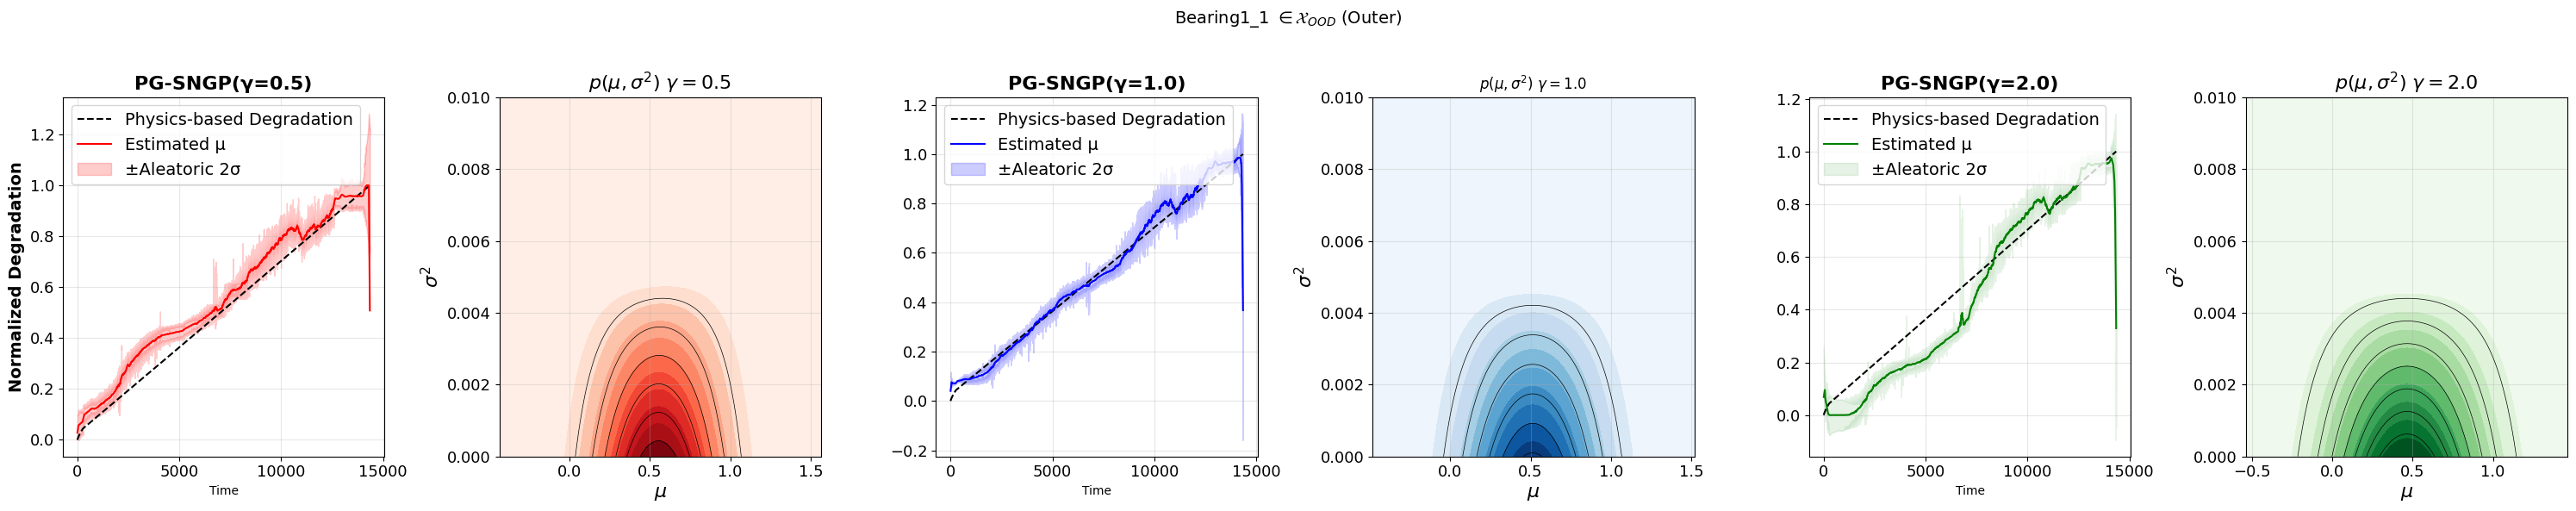

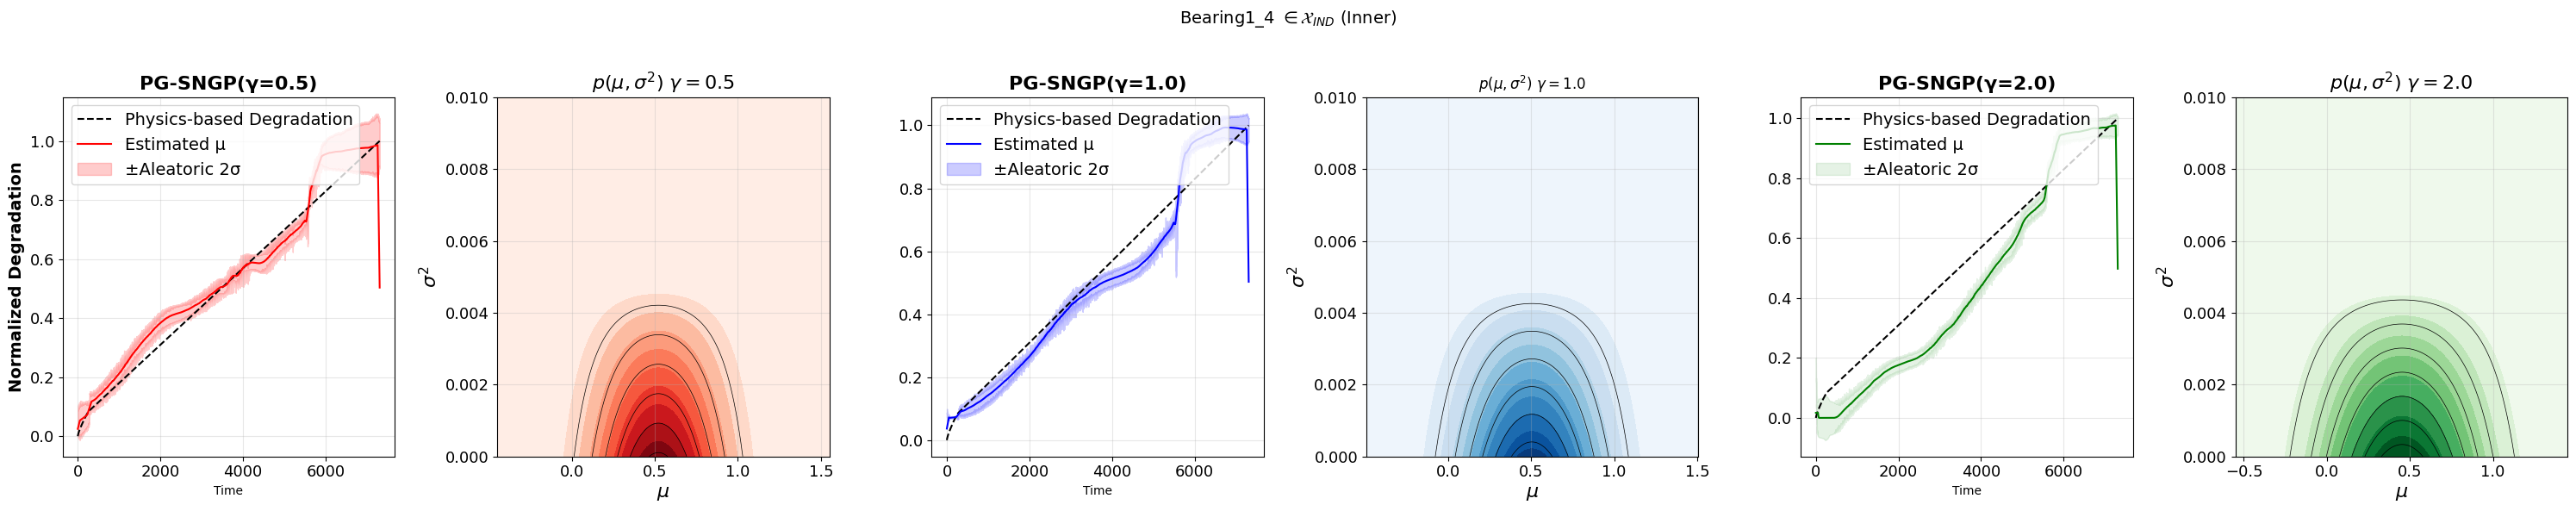

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import multivariate_normal
from networks.UQ_networks import SNER_network, ER_network, SNGP_network, GP_network
from models.UQ_SNGP import UQ_SNGP
from models.UQ_SNER import UQ_SNER
from utils.preprocess import process_features, moving_average




# --- DIRECTORIES ---
dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')
save_dir = os.path.join(dir, 'bearing_plots')
os.makedirs(save_dir, exist_ok=True)

# --- BEARING GROUPS ---
bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer', 'data_dist': 'OOD'},
        {'name': 'Bearing1_4', 'failure': 'Inner','data_dist':'IND'},
        
]}

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13



def plot_contour(mu_values, var_values, ax,color):
    mu_mean = np.mean(mu_values)
    sigma2_mean = np.mean(var_values)
    cov = np.cov(np.vstack([mu_values, var_values]))
    cov += np.eye(2) * 1e-6

    mu = np.linspace(mu_mean - 1, mu_mean + 1, 200)
    sigma2 = np.linspace(max(1e-6, sigma2_mean - 1), sigma2_mean + 1, 200)
    MU, SIGMA2 = np.meshgrid(mu, sigma2)
    pos = np.dstack((MU, SIGMA2))

    rv = multivariate_normal([mu_mean, sigma2_mean], cov)
    Z = rv.pdf(pos)

    ax.contourf(MU, SIGMA2, Z, levels=10, cmap=color)
    ax.contour(MU, SIGMA2, Z, colors='black', linewidths=0.5)
    ax.set_xlabel(r'$\mu$', fontsize=16, fontweight='bold')
    ax.set_xlim(mu_mean - 1, mu_mean + 1)
    ax.set_ylim(0, 0.01)
    ax.set_ylabel(r'$\sigma^2$', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)

# --- LOAD MODELS ---
sngp_05 = UQ_SNGP(SNGP_network, gamma=0.5)
sngp_05.load_weights(os.path.join(weights_dir, 'PI_SNGP_gamma_05_weights.keras'))

sngp_1 = UQ_SNGP(SNGP_network, gamma=1.0)
sngp_1.model.load_weights(f'{weights_dir}/PI_SNGP_gamma_1_weights.keras')

sngp_2 = UQ_SNGP(SNGP_network, gamma=2.0)
sngp_2.model.load_weights(f'{weights_dir}/PI_SNGP_gamma_2_weights.keras')

# --- MAIN LOOP ---
# --- MAIN LOOP ---
plt.style.use('seaborn-v0_8-deep')

for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
            bearing_name = bearing['name']
            failure_type = bearing['failure']
            data_dist = bearing['data_dist']

            df = pd.read_csv(os.path.join(feature_dir, f'{bearing_name}_features.csv'))

            xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
            xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
            vibration_features = np.concatenate((xh, xv), axis=-1)
            t_data = np.array(df['Time'].values).reshape(-1, 1)
            T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)
            X = np.concatenate([vibration_features, t_data, T_data], axis=1)

            scaler = StandardScaler()
            X = scaler.fit_transform(X)

            y_true = np.array(df['Degradation'].values)

            # Predict from all three models
            sngp_05_mu, sngp_05_var = sngp_05.predict(X)
            sngp_1_mu, sngp_1_var = sngp_1.predict(X)
            sngp_2_mu, sngp_2_var = sngp_2.predict(X)

            sngp_05_mu = np.clip(sngp_05_mu, 0, 1)
            sngp_05_var = np.clip(sngp_05_var, 0, 1)
            sngp_1_mu = np.clip(sngp_1_mu, 0, 1)
            sngp_1_var = np.clip(sngp_1_var, 0, 1)
            sngp_2_mu = np.clip(sngp_2_mu, 0, 1)
            sngp_2_var = np.clip(sngp_2_var, 0, 1)

            sngp_05_var = moving_average(sngp_05_var)
            sngp_1_var = moving_average(sngp_1_var)
            sngp_2_var = moving_average(sngp_2_var)

            ma_05 = moving_average(sngp_05_mu)
            ma_1 = moving_average(sngp_1_mu)
            ma_2 = moving_average(sngp_2_mu)

            std_05 = np.sqrt(sngp_05_var)
            std_1 = np.sqrt(sngp_1_var)
            std_2 = np.sqrt(sngp_2_var)

            

            # --- PLOTTING ---
            fig, ax = plt.subplots(1, 6, figsize=(30, 6))
            fig.suptitle(rf"{bearing_name} $\in \mathcal{{X}}_{{{data_dist}}}$ ({failure_type})", fontsize=14)
            x_vals = np.arange(len(y_true))

            # γ = 0.5 prediction
            ax[0].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[0].plot(ma_05, label='Estimated μ', color='red')
            ax[0].fill_between(x_vals, sngp_05_mu - 2*std_05, sngp_05_mu + 2*std_05, color='red', alpha=0.2, label=r'±Aleatoric 2σ')
            ax[0].set_title("PG-SNGP(γ=0.5)", fontsize=16, fontweight='bold')
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel(f"Normalized Degradation", fontsize=14, fontweight='bold')
            ax[0].legend(loc='upper left', fontsize=14)
            ax[0].grid(True, alpha=0.3)

            # γ = 0.5 posterior
            plot_contour(sngp_05_mu, sngp_05_var, ax[1],color='Reds')
            ax[1].set_title(r"$p(\mu,\sigma^2)\ \gamma=0.5$", fontsize=16, fontweight='bold')

            # γ = 1.0 prediction
            ax[2].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[2].plot(ma_1, label='Estimated μ', color='blue')
            ax[2].fill_between(x_vals, sngp_1_mu - 2*std_1, sngp_1_mu + 2*std_1, color='blue', alpha=0.2, label=r'±Aleatoric 2σ')
            ax[2].set_title("PG-SNGP(γ=1.0)", fontsize=16, fontweight='bold')
            ax[2].set_xlabel('Time')
            ax[2].legend(loc='upper left', fontsize=14)
            ax[2].grid(True, alpha=0.3)

            # γ = 1.0 posterior
            plot_contour(sngp_1_mu, sngp_1_var, ax[3],color='Blues')
            ax[3].set_title(r"$p(\mu,\sigma^2)\ \gamma=1.0$", fontsize=12, fontweight='bold')

            # γ = 2.0 prediction
            ax[4].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[4].plot(ma_2, label='Estimated μ', color='green')
            ax[4].fill_between(x_vals, sngp_2_mu - 2*std_2, sngp_2_mu + 2*std_2, color='green', alpha=0.1, label=r'±Aleatoric 2σ')
            ax[4].set_title("PG-SNGP(γ=2.0)", fontsize=16, fontweight='bold')
            ax[4].set_xlabel('Time')
            ax[4].legend(loc='upper left', fontsize=14)
            ax[4].grid(True, alpha=0.3)

            # γ = 2.0 posterior
            plot_contour(sngp_2_mu, sngp_2_var, ax[5],color='Greens')
            ax[5].set_title(r"$p(\mu,\sigma^2)\ \gamma=2.0$", fontsize=16, fontweight='bold')

            fig.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
            fig.savefig(os.path.join(save_dir, f'SNGP_{bearing_name}.png'),dpi=600)
            plt.close(fig)

        except Exception as e:
            print(f"Error processing {bearing_name}: {e}")

Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNER_lambda_02_weights.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNER_lambda_05_weights.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNER_lambda_1_weights.keras


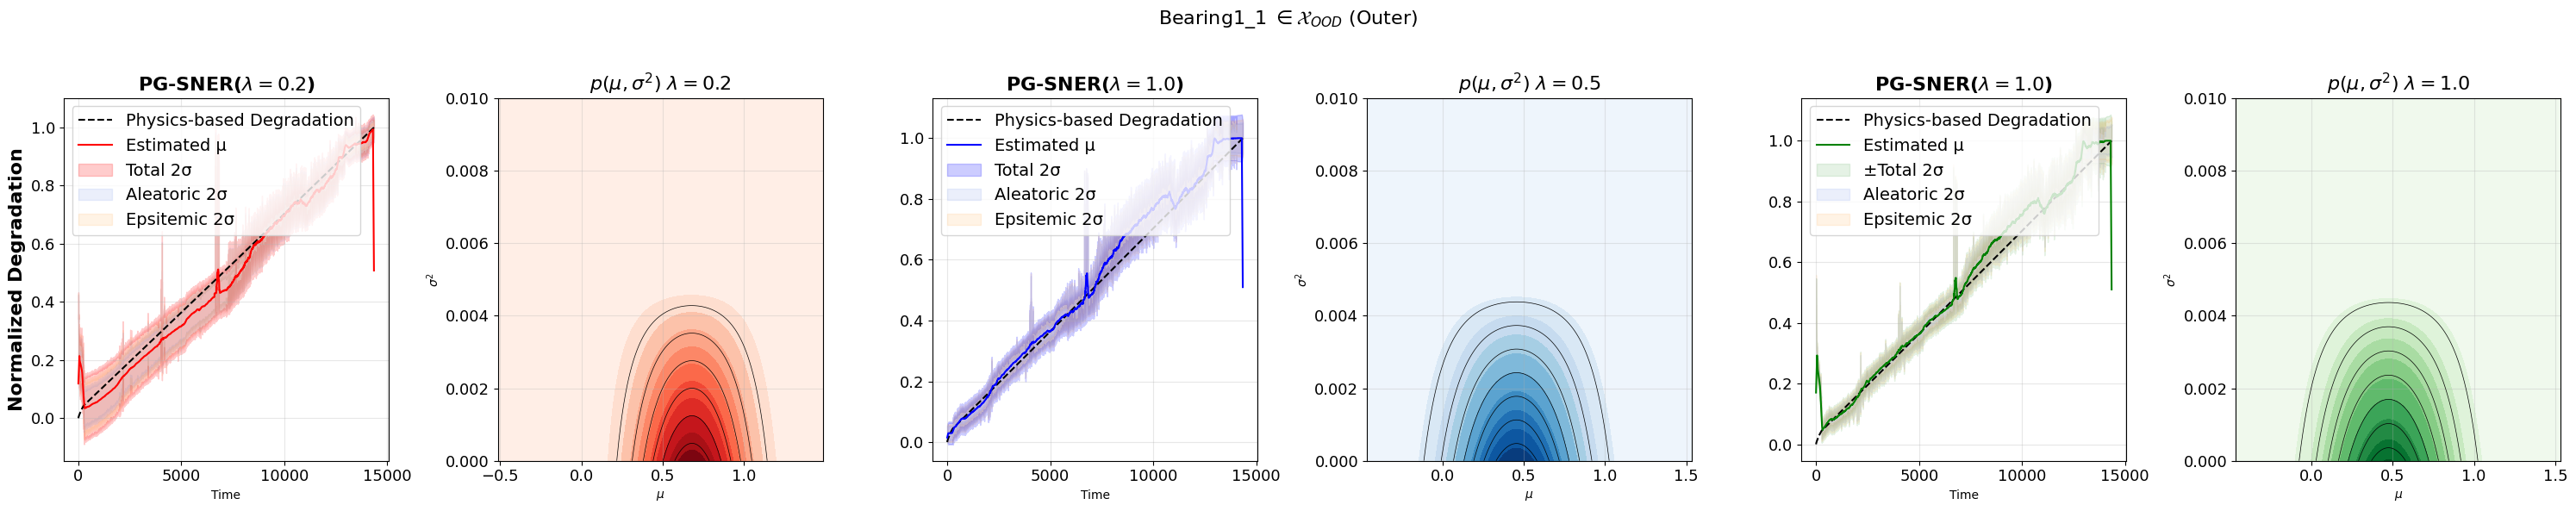

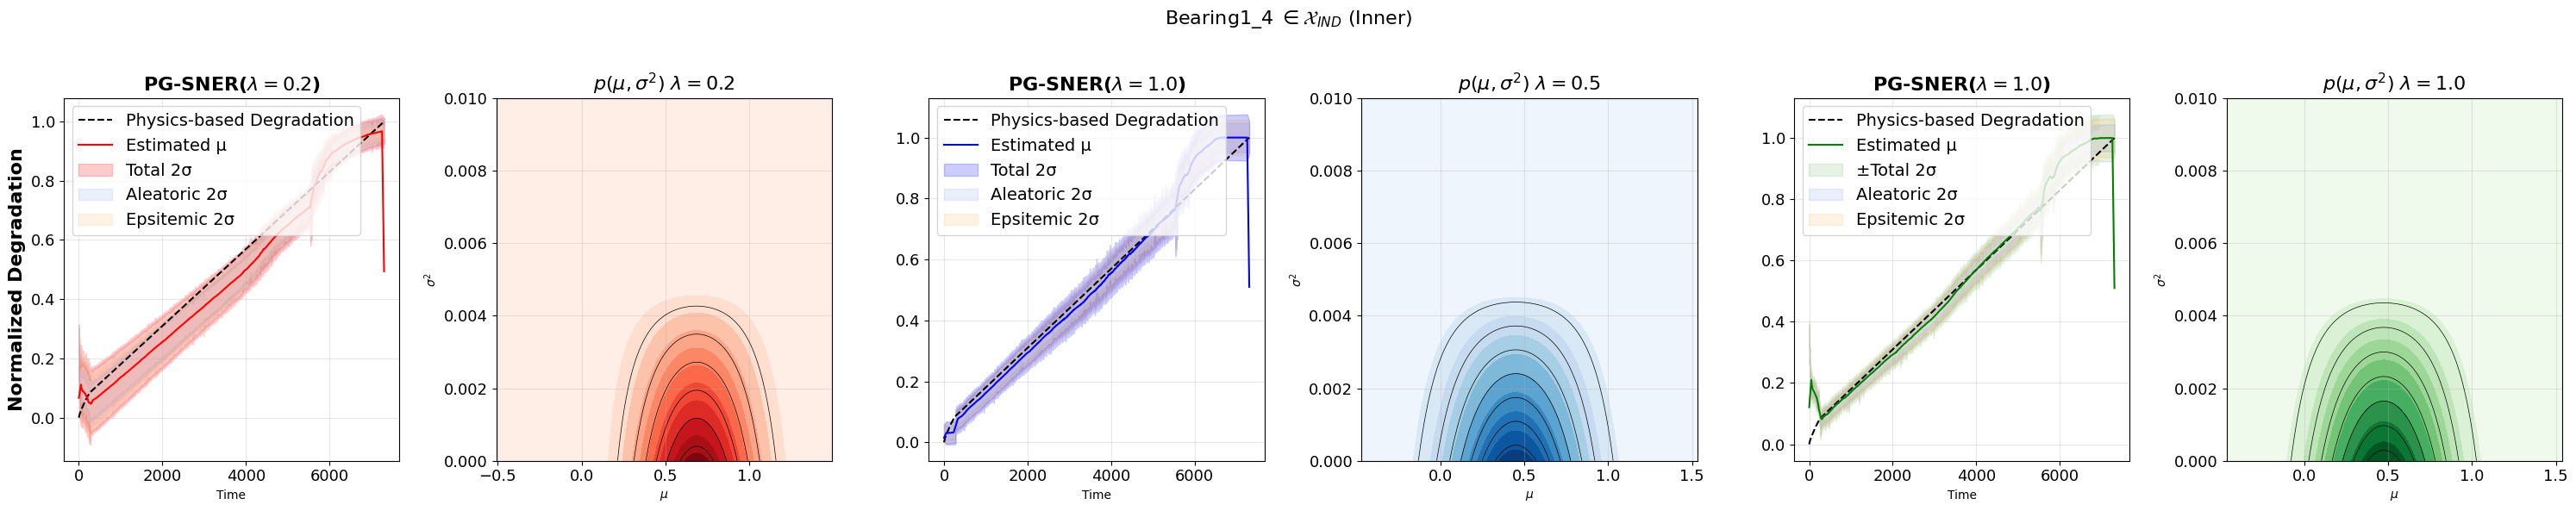

In [2]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import multivariate_normal
from networks.UQ_networks import SNER_network, ER_network, SNGP_network, GP_network
from models.UQ_SNGP import UQ_SNGP
from models.UQ_SNER import UQ_SNER
from utils.preprocess import process_features, moving_average


plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13


# --- DIRECTORIES ---
dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')
save_dir = os.path.join(dir, 'bearing_plots')
os.makedirs(save_dir, exist_ok=True)

# --- BEARING GROUPS ---
bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer', 'data_dist': 'OOD'},
        {'name': 'Bearing1_4', 'failure': 'Inner','data_dist':'IND'},
        
]}





def plot_contour(mu_values, var_values, ax,color):
    mu_mean = np.mean(mu_values)
    sigma2_mean = np.mean(var_values)
    cov = np.cov(np.vstack([mu_values, var_values]))
    cov += np.eye(2) * 1e-6

    mu = np.linspace(mu_mean - 1, mu_mean + 1, 200)
    sigma2 = np.linspace(max(1e-6, sigma2_mean - 1), sigma2_mean + 1, 200)
    MU, SIGMA2 = np.meshgrid(mu, sigma2)
    pos = np.dstack((MU, SIGMA2))

    rv = multivariate_normal([mu_mean, sigma2_mean], cov)
    Z = rv.pdf(pos)

    ax.contourf(MU, SIGMA2, Z, levels=10, cmap=color)
    ax.contour(MU, SIGMA2, Z, colors='black', linewidths=0.5)
    ax.set_xlabel(r'$\mu$')
    ax.set_xlim(mu_mean - 1, mu_mean + 1)
    ax.set_ylim(0, 0.01)
    ax.set_ylabel(r'$\sigma^2$')
    ax.grid(True, alpha=0.3)

# --- LOAD MODELS ---
sner_02 = UQ_SNER(SNER_network, lambbda=0.2)
sner_02.load_weights(os.path.join(weights_dir, 'PI_SNER_lambda_02_weights.keras'))

sner_05 = UQ_SNER(SNER_network, lambbda=0.5)
sner_05.load_weights(os.path.join(weights_dir, 'PI_SNER_lambda_05_weights.keras'))

sner_1 = UQ_SNER(SNER_network, lambbda=1.0)
sner_1.load_weights(os.path.join(weights_dir, 'PI_SNER_lambda_1_weights.keras'))

# --- MAIN LOOP ---
# --- MAIN LOOP ---

color_aleatoric = 'royalblue'
color_epistemic = 'darkorange'
plt.style.use('seaborn-v0_8-deep')

for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
            bearing_name = bearing['name']
            failure_type = bearing['failure']
            data_dist = bearing['data_dist']

            df = pd.read_csv(os.path.join(feature_dir, f'{bearing_name}_features.csv'))

            xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
            xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
            vibration_features = np.concatenate((xh, xv), axis=-1)
            t_data = np.array(df['Time'].values).reshape(-1, 1)
            T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)
            X = np.concatenate([vibration_features, t_data, T_data], axis=1)

            scaler = StandardScaler()
            X = scaler.fit_transform(X)

            y_true = np.array(df['Degradation'].values)

            mu_05, aleatoric_05, epistemic_05, total_05 = sner_02._predict(X)

            mu_1, aleatoric_1, epistemic_1, total_1 = sner_05._predict(X)

            mu_2, aleatoric_2, epistemic_2, total_2 = sner_1._predict(X)
            
            mu_05 = np.clip(mu_05, 0, 1)
            total_05 = np.clip(total_05, 0, 1)
            mu_1 = np.clip(mu_1, 0, 1)
            total_1 = np.clip(total_1, 0, 1)
            mu_2 = np.clip(mu_2, 0, 1)
            total_2 = np.clip(total_2, 0, 1)

            sngp_05_var = moving_average(total_05)
            sngp_1_var = moving_average(total_1)
            sngp_2_var = moving_average(total_2)

            ma_05 = moving_average(mu_05)
            ma_1 = moving_average(mu_1)
            ma_2 = moving_average(mu_2)

            std_05 = np.sqrt(sngp_05_var)
            std_1 = np.sqrt(sngp_1_var)
            std_2 = np.sqrt(sngp_2_var)

            

            # --- PLOTTING ---
            fig, ax = plt.subplots(1, 6, figsize=(30, 6))
            fig.suptitle(rf"{bearing_name} $\in \mathcal{{X}}_{{{data_dist}}}$ ({failure_type})", fontsize=16)
            x_vals = np.arange(len(y_true))

            # γ = 0.5 prediction
            ax[0].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[0].plot(ma_05, label='Estimated μ', color='red')
            ax[0].fill_between(x_vals, mu_05 - 2*std_05, mu_05 + 2*std_05, color='red', alpha=0.2, label=r'Total 2σ')
            ax[0].fill_between(x_vals, mu_05-2*np.sqrt(aleatoric_05), mu_05+2*np.sqrt(aleatoric_05), color='royalblue', alpha=0.1, label=r'Aleatoric 2σ')
            ax[0].fill_between(x_vals, mu_05-2*np.sqrt(epistemic_05), mu_05+2*np.sqrt(epistemic_05), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[0].set_title(r"PG-SNER($\lambda=0.2$)", fontsize=16, fontweight='bold')
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel(f"Normalized Degradation", fontsize=16, fontweight='bold')
            ax[0].legend(loc='upper left', fontsize=14)
            ax[0].grid(True, alpha=0.3)

            # γ = 0.5 posterior
            plot_contour(mu_05, sngp_05_var, ax[1],color='Reds')
            ax[1].set_title(r"$p(\mu,\sigma^2)\ \lambda=0.2$", fontsize=16, fontweight='bold')

            # γ = 1.0 prediction
            ax[2].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[2].plot(ma_1, label='Estimated μ', color='blue')
            ax[2].fill_between(x_vals, mu_1 - 2*std_1, mu_1 + 2*std_1, color='blue', alpha=0.2, label=r'Total 2σ')
            ax[2].fill_between(x_vals, mu_1-2*np.sqrt(aleatoric_1), mu_1+2*np.sqrt(aleatoric_1), color='royalblue', alpha=0.1, label=r'Aleatoric 2σ')
            ax[2].fill_between(x_vals, mu_1-2*np.sqrt(epistemic_1), mu_1+2*np.sqrt(epistemic_1), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[2].set_title(r"PG-SNER($\lambda=1.0$)", fontsize=16, fontweight='bold')
            ax[2].set_xlabel('Time')
            ax[2].legend(loc='upper left', fontsize=14)
            ax[2].grid(True, alpha=0.3)

            # γ = 1.0 posterior
            plot_contour(mu_1, sngp_1_var, ax[3],color='Blues')
            ax[3].set_title(r"$p(\mu,\sigma^2)\ \lambda=0.5$", fontsize=16, fontweight='bold')

            # γ = 2.0 prediction
            ax[4].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[4].plot(ma_2, label='Estimated μ', color='green')
            ax[4].fill_between(x_vals, mu_2 - 2*std_2, mu_2 + 2*std_2, color='green', alpha=0.1, label=r'±Total 2σ')
            ax[4].fill_between(x_vals, mu_2-2*np.sqrt(aleatoric_2), mu_2+2*np.sqrt(aleatoric_2), color='royalblue', alpha=0.1, label=r'Aleatoric 2σ')
            ax[4].fill_between(x_vals, mu_2-2*np.sqrt(epistemic_2), mu_2+2*np.sqrt(epistemic_2), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[4].set_title(r"PG-SNER($\lambda=1.0$)", fontsize=16, fontweight='bold')
            ax[4].set_xlabel('Time')
            ax[4].legend(loc='upper left', fontsize=14)
            ax[4].grid(True, alpha=0.3)

            # γ = 2.0 posterior
            plot_contour(mu_2, sngp_2_var, ax[5],color='Greens')
            ax[5].set_title(r"$p(\mu,\sigma^2)\ \lambda=1.0$", fontsize=16, fontweight='bold')

            fig.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
            fig.savefig(os.path.join(save_dir, f'SNER_{bearing_name}.png'),dpi=600)
            plt.close(fig)

        except Exception as e:
            print(f"Error processing {bearing_name}: {e}")

Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_MC.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_MC.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_MC.keras


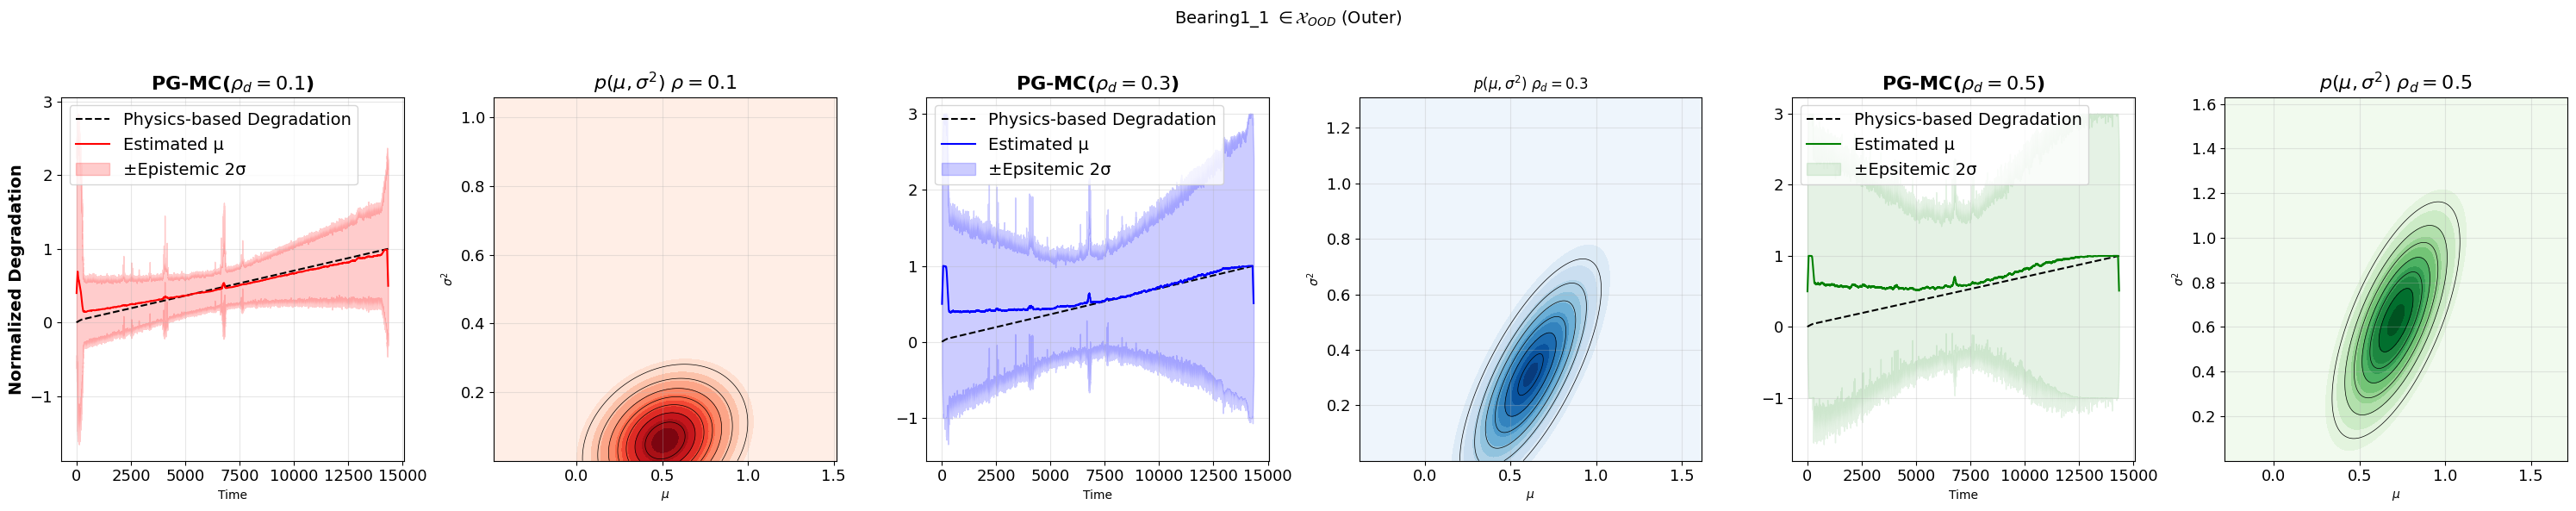

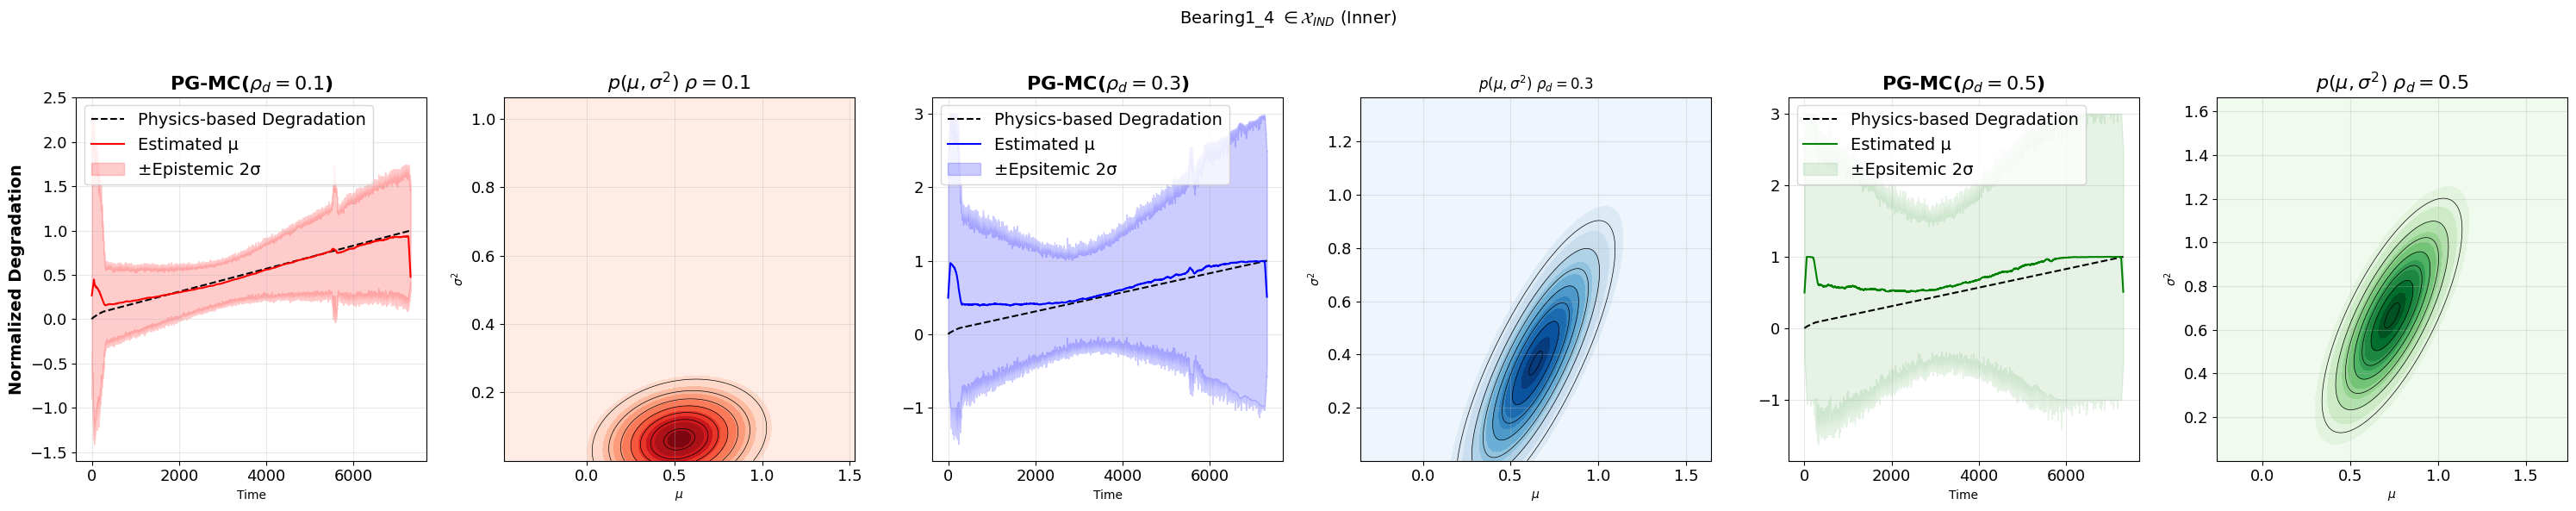

In [3]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import multivariate_normal
from networks.UQ_networks import SNER_network, ER_network, SNGP_network, GP_network,mc_network
from models.UQ_SNGP import UQ_SNGP
from models.UQ_SNER import UQ_SNER
from models.UQ_MC import UQ_MC
from utils.preprocess import process_features, moving_average

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13



# --- DIRECTORIES ---
dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')
save_dir = os.path.join(dir, 'bearing_plots')
os.makedirs(save_dir, exist_ok=True)

# --- BEARING GROUPS ---
bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer', 'data_dist': 'OOD'},
        {'name': 'Bearing1_4', 'failure': 'Inner','data_dist':'IND'},
        
]
}



def plot_contour(mu_values, var_values, ax,color):
    mu_mean = np.mean(mu_values)
    sigma2_mean = np.mean(var_values)
    cov = np.cov(np.vstack([mu_values, var_values]))
    cov += np.eye(2) * 1e-6

    mu = np.linspace(mu_mean - 1, mu_mean + 1, 200)
    sigma2 = np.linspace(max(1e-6, sigma2_mean - 1), sigma2_mean + 1, 200)
    MU, SIGMA2 = np.meshgrid(mu, sigma2)
    pos = np.dstack((MU, SIGMA2))

    rv = multivariate_normal([mu_mean, sigma2_mean], cov)
    Z = rv.pdf(pos)

    ax.contourf(MU, SIGMA2, Z, levels=10, cmap=color)
    ax.contour(MU, SIGMA2, Z, colors='black', linewidths=0.5)
    ax.set_xlabel(r'$\mu$')
    ax.set_xlim(mu_mean - 1, mu_mean + 1)
    ax.set_ylabel(r'$\sigma^2$')
    ax.grid(True, alpha=0.3)

# --- LOAD MODELS ---

sngp_05 = UQ_MC(mc_network,dropout_rate=0.1)
sngp_05.load_weights(os.path.join(weights_dir, 'PI_MC.keras'))

sngp_1 = UQ_MC(mc_network,dropout_rate=0.3)
sngp_1.load_weights(os.path.join(weights_dir, 'PI_MC.keras'))

sngp_2 = UQ_MC(mc_network,dropout_rate=0.4)
sngp_2.load_weights(os.path.join(weights_dir, 'PI_MC.keras'))



# --- MAIN LOOP ---
# --- MAIN LOOP ---
plt.style.use('seaborn-v0_8-deep')

for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
            bearing_name = bearing['name']
            failure_type = bearing['failure']
            data_dist = bearing['data_dist']

            df = pd.read_csv(os.path.join(feature_dir, f'{bearing_name}_features.csv'))

            xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
            xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
            vibration_features = np.concatenate((xh, xv), axis=-1)
            t_data = np.array(df['Time'].values).reshape(-1, 1)
            T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)
            X = np.concatenate([vibration_features, t_data, T_data], axis=1)

            scaler = StandardScaler()
            X = scaler.fit_transform(X)

            y_true = np.array(df['Degradation'].values)

            # Predict from all three models
            sngp_05_mu, sngp_05_var = sngp_05._predict(X)
            sngp_1_mu, sngp_1_var = sngp_1._predict(X)
            sngp_2_mu, sngp_2_var = sngp_2._predict(X)

            sngp_05_mu = np.clip(sngp_05_mu, 0, 1)
            sngp_05_var = np.clip(sngp_05_var, 0, 1)
            sngp_1_mu = np.clip(sngp_1_mu, 0, 1)
            sngp_1_var = np.clip(sngp_1_var, 0, 1)
            sngp_2_mu = np.clip(sngp_2_mu, 0, 1)
            sngp_2_var = np.clip(sngp_2_var, 0, 1)

            sngp_05_var = moving_average(sngp_05_var)
            sngp_1_var = moving_average(sngp_1_var)
            sngp_2_var = moving_average(sngp_2_var)

            ma_05 = moving_average(sngp_05_mu)
            ma_1 = moving_average(sngp_1_mu)
            ma_2 = moving_average(sngp_2_mu)

            std_05 = np.sqrt(sngp_05_var)
            std_1 = np.sqrt(sngp_1_var)
            std_2 = np.sqrt(sngp_2_var)

            

            # --- PLOTTING ---
            fig, ax = plt.subplots(1, 6, figsize=(30, 6))
            fig.suptitle(rf"{bearing_name} $\in \mathcal{{X}}_{{{data_dist}}}$ ({failure_type})", fontsize=14)
            x_vals = np.arange(len(y_true))

            # γ = 0.5 prediction
            ax[0].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[0].plot(ma_05, label='Estimated μ', color='red')
            ax[0].fill_between(x_vals, sngp_05_mu - 2*std_05, sngp_05_mu + 2*std_05, color='red', alpha=0.2, label=r'±Epistemic 2σ')
            ax[0].set_title(r"PG-MC($\rho_d=0.1$)", fontsize=16, fontweight='bold')
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel(f"Normalized Degradation", fontsize=14, fontweight='bold')
            ax[0].legend(loc='upper left', fontsize=14)
            ax[0].grid(True, alpha=0.3)

            # γ = 0.5 posterior
            plot_contour(sngp_05_mu, sngp_05_var, ax[1],color='Reds')
            ax[1].set_title(r"$p(\mu,\sigma^2)\ \rho=0.1$", fontsize=16, fontweight='bold')

            # γ = 1.0 prediction
            ax[2].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[2].plot(ma_1, label='Estimated μ', color='blue')
            ax[2].fill_between(x_vals, sngp_1_mu - 2*std_1, sngp_1_mu + 2*std_1, color='blue', alpha=0.2, label=r'±Epsitemic 2σ')
            ax[2].set_title(r"PG-MC($\rho_d=0.3$)", fontsize=16, fontweight='bold')
            ax[2].set_xlabel('Time')
            ax[2].legend(loc='upper left', fontsize=14)
            ax[2].grid(True, alpha=0.3)

            # γ = 1.0 posterior
            plot_contour(sngp_1_mu, sngp_1_var, ax[3],color='Blues')
            ax[3].set_title(r"$p(\mu,\sigma^2)\ \rho_d=0.3$", fontsize=12, fontweight='bold')

            # γ = 2.0 prediction
            ax[4].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[4].plot(ma_2, label='Estimated μ', color='green')
            ax[4].fill_between(x_vals, sngp_2_mu - 2*std_2, sngp_2_mu + 2*std_2, color='green', alpha=0.1, label=r'±Epsitemic 2σ')
            ax[4].set_title(r"PG-MC($\rho_d=0.5$)", fontsize=16, fontweight='bold')
            ax[4].set_xlabel('Time')
            ax[4].legend(loc='upper left', fontsize=14)
            ax[4].grid(True, alpha=0.3)

            # γ = 2.0 posterior
            plot_contour(sngp_2_mu, sngp_2_var, ax[5],color='Greens')
            ax[5].set_title(r"$p(\mu,\sigma^2)\ \rho_d=0.5$", fontsize=16, fontweight='bold')

            fig.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
            fig.savefig(os.path.join(save_dir, f'MC{bearing_name}.png'),dpi=600)
            plt.close(fig)

        except Exception as e:
            print(f"Error processing {bearing_name}: {e}")

Loaded weights from: /home/waleed/phd_pgnn/model_weights/mlp_net.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/mlp_net.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/mlp_net.keras


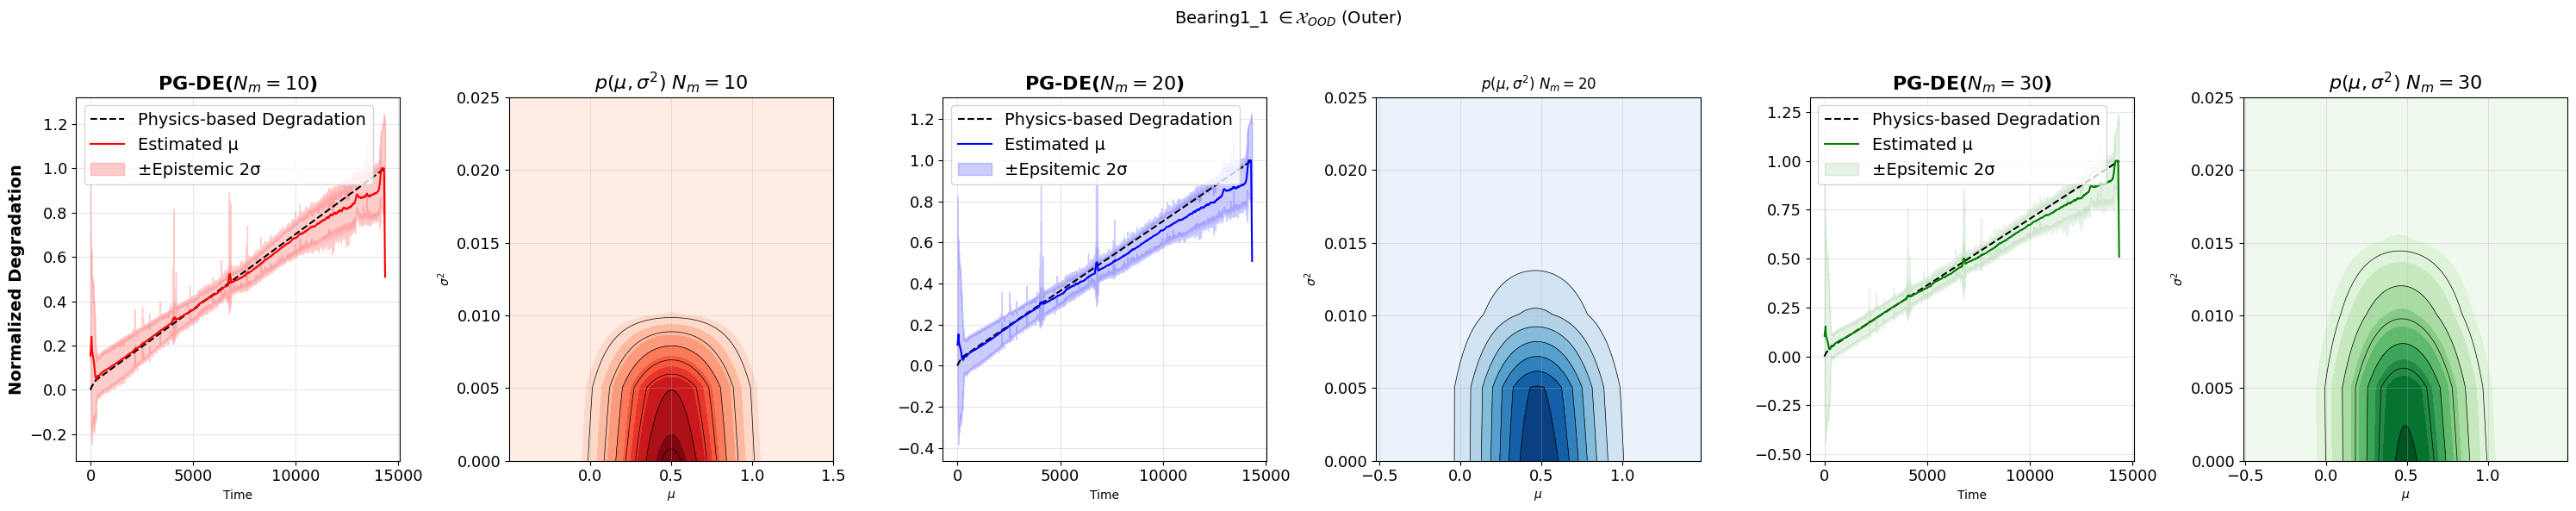

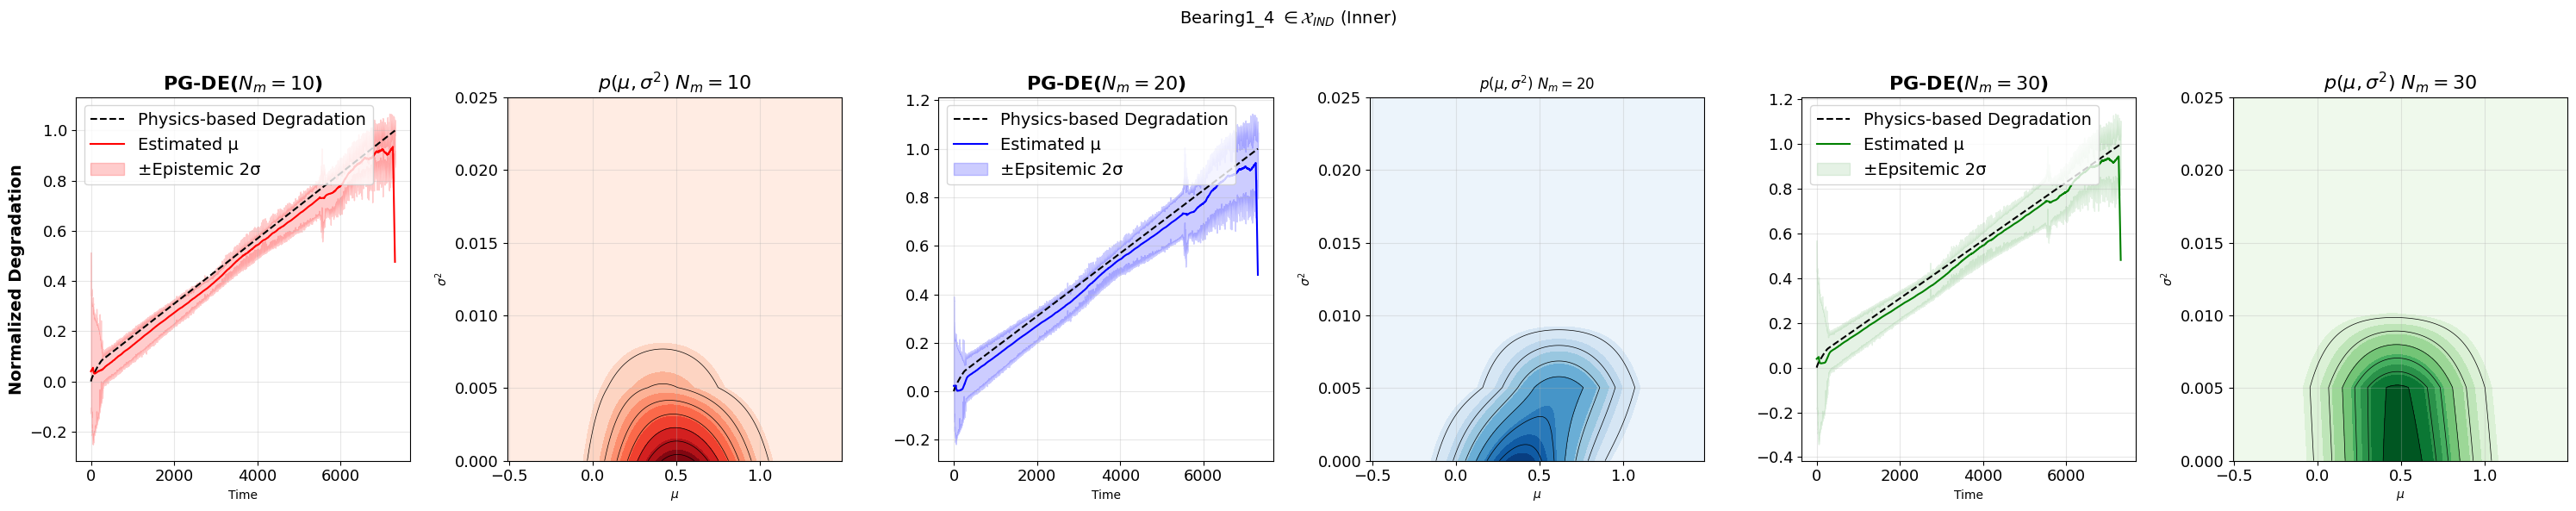

In [4]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import multivariate_normal
from networks.UQ_networks import SNER_network, ER_network, SNGP_network, GP_network,mc_network
from models.UQ_SNGP import UQ_SNGP
from models.UQ_SNER import UQ_SNER
from models.UQ_MC import UQ_MC
from models.UQ_DE import UQ_DE
from networks.networks import mlp_net
from utils.preprocess import process_features, moving_average
from utils.metrics import score_function


plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13


# --- DIRECTORIES ---
dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')
save_dir = os.path.join(dir, 'bearing_plots')
os.makedirs(save_dir, exist_ok=True)

# --- BEARING GROUPS ---
bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer', 'data_dist': 'OOD'},
        {'name': 'Bearing1_4', 'failure': 'Inner','data_dist':'IND'},
        
]
}



def plot_contour(mu_values, var_values, ax,color):
    mu_mean = np.mean(mu_values)
    sigma2_mean = np.mean(var_values)
    cov = np.cov(np.vstack([mu_values, var_values]))
    cov += np.eye(2) * 1e-6

    mu = np.linspace(mu_mean - 1, mu_mean + 1, 200)
    sigma2 = np.linspace(max(1e-6, sigma2_mean - 1), sigma2_mean + 1, 200)
    MU, SIGMA2 = np.meshgrid(mu, sigma2)
    pos = np.dstack((MU, SIGMA2))

    rv = multivariate_normal([mu_mean, sigma2_mean], cov)
    Z = rv.pdf(pos)

    ax.contourf(MU, SIGMA2, Z, levels=10, cmap=color)
    ax.contour(MU, SIGMA2, Z, colors='black', linewidths=0.5)
    ax.set_xlabel(r'$\mu$')
    ax.set_xlim(mu_mean - 1, mu_mean + 1)
    ax.set_ylabel(r'$\sigma^2$')
    ax.grid(True, alpha=0.3)

# --- LOAD MODELS ---

sngp_05 = UQ_DE(mlp_net)
sngp_05.load_weights(os.path.join(weights_dir, 'mlp_net.keras'))

sngp_1 = UQ_DE(mlp_net)
sngp_1.load_weights(os.path.join(weights_dir, 'mlp_net.keras'))

sngp_2 = UQ_DE(mlp_net)
sngp_2.load_weights(os.path.join(weights_dir, 'mlp_net.keras'))



# --- MAIN LOOP ---
# --- MAIN LOOP ---
plt.style.use('seaborn-v0_8-deep')

for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
            bearing_name = bearing['name']
            failure_type = bearing['failure']
            data_dist = bearing['data_dist']

            df = pd.read_csv(os.path.join(feature_dir, f'{bearing_name}_features.csv'))

            xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
            xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
            vibration_features = np.concatenate((xh, xv), axis=-1)
            t_data = np.array(df['Time'].values).reshape(-1, 1)
            T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)
            X = np.concatenate([vibration_features, t_data, T_data], axis=1)

            scaler = StandardScaler()
            X = scaler.fit_transform(X)

            y_true = np.array(df['Degradation'].values)

            # Predict from all three models
            sngp_05_mu, sngp_05_var = sngp_05._predict(X,num_models=10)
            sngp_1_mu, sngp_1_var = sngp_1._predict(X,num_models=20)
            sngp_2_mu, sngp_2_var = sngp_2._predict(X,num_models=30)

            sngp_05_mu = np.clip(sngp_05_mu, 0, 1)
            sngp_05_var = np.clip(sngp_05_var, 0, 1)
            sngp_1_mu = np.clip(sngp_1_mu, 0, 1)
            sngp_1_var = np.clip(sngp_1_var, 0, 1)
            sngp_2_mu = np.clip(sngp_2_mu, 0, 1)
            sngp_2_var = np.clip(sngp_2_var, 0, 1)

            sngp_05_var = moving_average(sngp_05_var)
            sngp_1_var = moving_average(sngp_1_var)
            sngp_2_var = moving_average(sngp_2_var)

            ma_05 = moving_average(sngp_05_mu)
            ma_1 = moving_average(sngp_1_mu)
            ma_2 = moving_average(sngp_2_mu)

            std_05 = np.sqrt(sngp_05_var)
            std_1 = np.sqrt(sngp_1_var)
            std_2 = np.sqrt(sngp_2_var)

            

            # --- PLOTTING ---
            fig, ax = plt.subplots(1, 6, figsize=(30, 6))
            fig.suptitle(rf"{bearing_name} $\in \mathcal{{X}}_{{{data_dist}}}$ ({failure_type})", fontsize=14)
            x_vals = np.arange(len(y_true))

            # γ = 0.5 prediction
            ax[0].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[0].plot(ma_05, label='Estimated μ', color='red')
            ax[0].fill_between(x_vals, sngp_05_mu - 2*std_05, sngp_05_mu + 2*std_05, color='red', alpha=0.2, label=r'±Epistemic 2σ')
            ax[0].set_title(r"PG-DE($N_m=10$)", fontsize=16, fontweight='bold')
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel(f"Normalized Degradation", fontsize=14, fontweight='bold')
            ax[0].legend(loc='upper left', fontsize=14)
            ax[0].grid(True, alpha=0.3)

            # γ = 0.5 posterior
            plot_contour(sngp_05_mu, sngp_05_var, ax[1],color='Reds')
            ax[1].set_title(r"$p(\mu,\sigma^2)\ N_m=10$", fontsize=16, fontweight='bold')
            ax[1].set_ylim(0, 0.025)


            # γ = 1.0 prediction
            ax[2].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[2].plot(ma_1, label='Estimated μ', color='blue')
            ax[2].fill_between(x_vals, sngp_1_mu - 2*std_1, sngp_1_mu + 2*std_1, color='blue', alpha=0.2, label=r'±Epsitemic 2σ')
            ax[2].set_title(r"PG-DE($N_m=20$)", fontsize=16, fontweight='bold')
            ax[2].set_xlabel('Time')
            ax[2].legend(loc='upper left', fontsize=14)
            ax[2].grid(True, alpha=0.3)

            # γ = 1.0 posterior
            plot_contour(sngp_1_mu, sngp_1_var, ax[3],color='Blues')
            ax[3].set_title(r"$p(\mu,\sigma^2)\ N_m=20$", fontsize=12, fontweight='bold')
            ax[3].set_ylim(0, 0.025)

            # γ = 2.0 prediction
            ax[4].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[4].plot(ma_2, label='Estimated μ', color='green')
            ax[4].fill_between(x_vals, sngp_2_mu - 2*std_2, sngp_2_mu + 2*std_2, color='green', alpha=0.1, label=r'±Epsitemic 2σ')
            ax[4].set_title(r"PG-DE($N_m=30$)", fontsize=16, fontweight='bold')
            ax[4].set_xlabel('Time')
            ax[4].legend(loc='upper left', fontsize=14)
            ax[4].grid(True, alpha=0.3)

            # γ = 2.0 posterior
            plot_contour(sngp_2_mu, sngp_2_var, ax[5],color='Greens')
            ax[5].set_title(r"$p(\mu,\sigma^2)\ N_m=30$", fontsize=16, fontweight='bold')
            ax[5].set_ylim(0, 0.025)

            fig.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
            fig.savefig(os.path.join(save_dir, f'DE{bearing_name}.png'),dpi=600)
            plt.close(fig)

        except Exception as e:
            print(f"Error processing {bearing_name}: {e}")

Metric

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.metrics import score_function
from sklearn.preprocessing import StandardScaler
from utils.preprocess import moving_average
from networks.UQ_networks import SNER_network, ER_network, SNGP_network, GP_network,mc_network
from models.UQ_SNGP import UQ_SNGP
from models.UQ_SNER import UQ_SNER
from models.UQ_MC import UQ_MC
from models.UQ_DE import UQ_DE
from networks.networks import mlp_net
from utils.preprocess import process_features, moving_average
from utils.metrics import score_function

# --- DIRECTORIES ---
dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')
os.makedirs(stats_dir, exist_ok=True)


plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13


# --- BEARING GROUPS ---
bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer', 'data_dist': 'OOD'},
        {'name': 'Bearing1_4', 'failure': 'Inner', 'data_dist': 'IND'},
    ]
}

# --- LOAD MODELS WITH METHOD NAME INCLUDED ---
models = [
    ('PG-SNGP', UQ_SNGP(SNGP_network, gamma=0.5), {'param': 'gamma', 'value': 0.5, 'file': 'PI_SNGP_gamma_05_weights.keras', 'method': 'predict'}),
    ('PG-SNGP', UQ_SNGP(SNGP_network, gamma=1.0), {'param': 'gamma', 'value': 1.0, 'file': 'PI_SNGP_gamma_1_weights.keras', 'method': 'predict'}),
    ('PG-SNGP', UQ_SNGP(SNGP_network, gamma=2.0), {'param': 'gamma', 'value': 2.0, 'file': 'PI_SNGP_gamma_2_weights.keras', 'method': 'predict'}),

    ('PG-SNER', UQ_SNER(SNER_network, lambbda=0.2), {'param': 'lambda', 'value': 0.2, 'file': 'PI_SNER_lambda_02_weights.keras', 'method': 'predict'}),
    ('PG-SNER', UQ_SNER(SNER_network, lambbda=0.5), {'param': 'lambda', 'value': 0.5, 'file': 'PI_SNER_lambda_05_weights.keras', 'method': 'predict'}),
    ('PG-SNER', UQ_SNER(SNER_network, lambbda=1.0), {'param': 'lambda', 'value': 1.0, 'file': 'PI_SNER_lambda_1_weights.keras', 'method': 'predict'}),

    ('PG-MC', UQ_MC(mc_network, dropout_rate=0.1), {'param': 'dropout_rate', 'value': 0.1, 'file': 'PI_MC.keras', 'method': '_predict'}),
    ('PG-MC', UQ_MC(mc_network, dropout_rate=0.3), {'param': 'dropout_rate', 'value': 0.3, 'file': 'PI_MC.keras', 'method': '_predict'}),
    ('PG-MC', UQ_MC(mc_network, dropout_rate=0.4), {'param': 'dropout_rate', 'value': 0.4, 'file': 'PI_MC.keras', 'method': '_predict'}),

    ('PG-DE', UQ_DE(mlp_net), {'param': 'num_models', 'value': 10, 'file': 'mlp_net.keras', 'method': '_predict'}),
    ('PG-DE', UQ_DE(mlp_net), {'param': 'num_models', 'value': 20, 'file': 'mlp_net.keras', 'method': '_predict'}),
    ('PG-DE', UQ_DE(mlp_net), {'param': 'num_models', 'value': 30, 'file': 'mlp_net.keras', 'method': '_predict'}),
]

# --- Load weights ---
for model_name, model, config in models:
    model.load_weights(os.path.join(weights_dir, config['file']))
    config['model'] = model
    config['name'] = model_name

# --- Process each bearing separately ---
for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        results = []

        bearing_name = bearing['name']
        failure_type = bearing['failure']
        data_dist = bearing['data_dist']

        try:
            # Load and process features
            df = pd.read_csv(os.path.join(feature_dir, f'{bearing_name}_features.csv'))
            xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
            xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
            vibration_features = np.concatenate((xh, xv), axis=-1)
            t_data = np.array(df['Time'].values).reshape(-1, 1)
            T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)
            X = np.concatenate([vibration_features, t_data, T_data], axis=1)

            scaler = StandardScaler()
            X = scaler.fit_transform(X)

            y_true = np.array(df['Degradation'].values)

            # Loop over all models
            for config in models:
                model = config[2]['model']
                model_name = config[2]['name']
                param_name = config[2]['param']
                param_value = config[2]['value']
                method = config[2]['method']

                try:
                    if method == 'predict':
                        mu, var = getattr(model, method)(X)
                    elif method == '_predict':
                        if model_name == 'PG-DE':
                            mu, var = getattr(model, method)(X, num_models=param_value)
                        else:
                            mu, var = getattr(model, method)(X)
                    else:
                        raise ValueError(f"Unknown method '{method}' for {model_name}")

                    mu = np.clip(mu, 0, 1)
                    var = np.clip(var, 0, 1)
                    mu = moving_average(mu)
                    var = moving_average(var)

                    mse = mean_squared_error(y_true, mu)
                    mae = mean_absolute_error(y_true, mu)
                    score = score_function(y_true, mu).numpy()

                    results.append({
                        'Bearing': bearing_name,
                        'Condition': condition,
                        'Model': model_name,
                        param_name: param_value,
                        'MSE': mse,
                        'MAE': mae,
                        'Score': score
                    })

                except Exception as model_err:
                    print(f"[!] Error in {model_name} ({param_value}) on {bearing_name}: {model_err}")

        except Exception as e:
            print(f"[!] Failed processing {bearing_name}: {e}")
            continue

        # Save per-bearing CSV
        df_result = pd.DataFrame(results)
        save_path = os.path.join(stats_dir, f'PG_metrics_{bearing_name}.csv')
        df_result.to_csv(save_path, index=False)
        print(f"[✓] Saved metrics for {bearing_name} → {save_path}")


/home/waleed/.local/lib/python3.10/site-packages/tf_keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomUniform'>, which may lead to improper serialization.
  warnings.warn(


Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNGP_gamma_05_weights.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNGP_gamma_1_weights.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNGP_gamma_2_weights.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNER_lambda_02_weights.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNER_lambda_05_weights.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNER_lambda_1_weights.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_MC.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_MC.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_MC.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/mlp_net.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/mlp_net.keras
Loaded weights from: /home/waleed/phd_pgnn/model_weights/mlp_net.keras


2025-08-09 10:16:03.575076: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 823690000 exceeds 10% of free system memory.
2025-08-09 10:16:09.482626: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 823690000 exceeds 10% of free system memory.


[✓] Saved metrics for Bearing1_1 → /home/waleed/phd_pgnn/statistics/PG_metrics_Bearing1_1.csv
[✓] Saved metrics for Bearing1_4 → /home/waleed/phd_pgnn/statistics/PG_metrics_Bearing1_4.csv


: 

Noise Tests

SNGP

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import multivariate_normal
from models.UQ_SNGP import UQ_SNGP
from networks.UQ_networks import SNGP_network
from utils.preprocess import process_features, moving_average
from networks.losses import NLL
# --- CONFIGURATION ---
p = 3.0
P = 4000.0
Ea = 0.1
kB = 8.617e-5
alpha = 1e-5
beta = 5e-6

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13


# --- DIRECTORIES ---
dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')
save_dir = os.path.join(dir, 'bearing_plots')
os.makedirs(save_dir, exist_ok=True)

# --- BEARING GROUPS ---
bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer', 'data_dist': 'OOD'},
        {'name': 'Bearing1_4', 'failure': 'Inner', 'data_dist': 'IND'},
    ],
}


import tensorflow as tf

def fgsm(model, input_image, input_label, epsilon):
    input_image = tf.cast(input_image, dtype=tf.float32)
    input_label = tf.cast(input_label, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        pred = model.model(input_image,training=False)
        loss = NLL(input_label,pred)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    adversarial_example = input_image + epsilon * signed_grad
    adversarial_example = tf.clip_by_value(adversarial_example, -5, 5)
    return adversarial_example




def plot_contour(mu_values, var_values, ax):
    mu_mean = np.mean(mu_values)
    sigma2_mean = np.mean(var_values)
    cov = np.cov(np.vstack([mu_values, var_values]))
    cov += np.eye(2) * 1e-6

    mu = np.linspace(mu_mean - 1, mu_mean + 1, 200)
    sigma2 = np.linspace(max(1e-6, sigma2_mean - 1), sigma2_mean + 1, 200)
    MU, SIGMA2 = np.meshgrid(mu, sigma2)
    pos = np.dstack((MU, SIGMA2))

    rv = multivariate_normal([mu_mean, sigma2_mean], cov)
    Z = rv.pdf(pos)

    ax.contourf(MU, SIGMA2, Z, levels=10, cmap='Blues')
    ax.contour(MU, SIGMA2, Z, colors='black', linewidths=0.5)
    ax.set_xlabel(r'$\mu$', fontsize=14)
    ax.set_xlim(mu_mean - 1, mu_mean + 1)
    ax.set_ylim(0, 0.01)
    ax.set_ylabel(r'$\sigma^2$', fontsize=14)
    ax.grid(True, alpha=0.3)

# --- LOAD MODELS ---
sngp = UQ_SNGP(SNGP_network, gamma=0.5)
sngp.load_weights(os.path.join(weights_dir, 'PI_SNGP_gamma_05_weights.keras'))

# --- MAIN LOOP ---
# --- MAIN LOOP ---
plt.style.use('seaborn-v0_8-deep')
epsilon_values = [0.01, 0.5, 1.0]

for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
            bearing_name = bearing['name']
            failure_type = bearing['failure']
            data_dist = bearing['data_dist']

            df = pd.read_csv(os.path.join(feature_dir, f'{bearing_name}_features.csv'))

            xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
            xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
            vibration_features = np.concatenate((xh, xv), axis=-1)
            t_data = np.array(df['Time'].values).reshape(-1, 1)
            T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)
            X = np.concatenate([vibration_features, t_data, T_data], axis=1)

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            y_true = np.array(df['Degradation'].values)

            mus = []
            vars_ = []
            stds = []
            mas = []

            for eps in epsilon_values:
                # Generate adversarial samples with fgsm
                X_adv = fgsm(sngp, X_scaled, y_true, epsilon=eps)

                # Predict on adversarial inputs
                mu_adv, var_adv = sngp.predict(X_scaled)

                mu_adv = np.clip(mu_adv, 0, 1)
                var_adv = np.clip(var_adv, 0, 1)
                std_adv = np.sqrt(var_adv)
                ma_adv = moving_average(mu_adv)

                mus.append(mu_adv)
                vars_.append(var_adv)
                stds.append(std_adv)
                mas.append(ma_adv)

            # --- PLOTTING ---
            fig, ax = plt.subplots(1, 6, figsize=(30, 6))
            fig.suptitle(f"{bearing_name} (Robustness under adversarial noise)", fontsize=14)
            x_vals = np.arange(len(y_true))

            colors = ['red', 'blue', 'green']
            contour_colors = ['Reds', 'Blues', 'Greens']
            titles = [f"PI-SNGP(ε={eps})" for eps in epsilon_values]

            for i, eps in enumerate(epsilon_values):
                idx = 2*i
                ax[idx].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
                ax[idx].plot(mas[i], label='Estimated μ', color=colors[i])
                ax[idx].fill_between(x_vals, mus[i] - 2*stds[i], mus[i] + 2*stds[i], color=colors[i], alpha=0.1, label=r'±Aleatoric 2σ')

                ax[idx].set_title(titles[i])
                ax[idx].set_xlabel('Time', fontsize=14)
                ax[idx].set_ylabel(f"Normalized Degradation", fontsize=14, fontweight='bold')
                ax[idx].legend(loc='upper left', fontsize=14)
                ax[idx].grid(True, alpha=0.3)

                plot_contour(mus[i], vars_[i], ax[idx+1])
                ax[idx+1].set_title(f"$p(\mu,\sigma^2)$",fontsize=16, fontweight='bold')

            fig.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
            fig.savefig(os.path.join(save_dir, f'SNGP_FGSM_{bearing_name}.png'), dpi=600)
            plt.close(fig)

        except Exception as e:
            print(f"Error processing {bearing_name}: {e}")


/home/waleed/.local/lib/python3.10/site-packages/tf_keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomUniform'>, which may lead to improper serialization.
  warnings.warn(


Loaded weights from: /home/waleed/phd_pgnn/model_weights/PI_SNGP_gamma_05_weights.keras
